# Section 2.1 - SINDy on Uniscale Systems

In [1]:
import numpy as np
import scipy.linalg as la
from scipy.integrate import ode
import scipy
from scipy import signal
import utils
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rc('font', size=14)

In [2]:
def find_boundary(coefficient_matrix, data):
    boundary_data = np.zeros(coefficient_matrix.shape[0])
    for i in range(boundary_data.size):
        nonzeros=np.nonzero(coefficient_matrix[i])
        if nonzeros[0].size==0:
            index=0
        else:
            index = np.max(nonzeros)+1
        if index==coefficient_matrix.shape[1]:
            boundary_data[i]=np.nan
        else:
            boundary_data[i]=data[index]
    return boundary_data

## Van der Pol oscillator

### Simulate the system

In [3]:
# set up parameters

tau = 1
mu = 5
period_length = 11.45015*tau

x0 = [0.0, 2.0]

Xi_true = np.zeros((10,2))
Xi_true[2,0] = 1
Xi_true[1,1] = -1
Xi_true[2,1] = mu
Xi_true[7,1] = -mu
Xi_true /= tau

poly_order = 3
coefficient_threshold = .1
tol = 1e-10

# simulate system
num_periods_simulate = 10
sampling_rate_simulate_exponent = 18
sampling_rate_simulate = 2**sampling_rate_simulate_exponent
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

vdp_simulation = utils.simulate_vanderpol_oscillator(dt_simulate, t_simulate_full.size,
                                                   x0=x0, mu=mu, tau=tau)[0]

### Subsample data and apply SINDy

In [4]:
test_durations = np.arange(.05,1,.05)
test_sampling_rates = np.arange(6,19)
test_starts = np.arange(0,1,.1)

extra_coefficients = np.zeros((test_durations.size, test_sampling_rates.size, test_starts.size))

for i,duration in enumerate(test_durations):
    for j,sampling_rate_exponent in enumerate(test_sampling_rates):
        for k,start_time in enumerate(test_starts):
            # get subsampled data
            initial_samples = int((5+start_time)*sampling_rate_simulate)
            t_simulate = t_simulate_full[initial_samples:]
            vdp_solution = vdp_simulation[:,initial_samples:]
            
            sampling_rate = 2**sampling_rate_exponent
            t_max_idx = int(duration*sampling_rate_simulate)+1
            spacing = sampling_rate_simulate//sampling_rate

            t_sample = t_simulate[:t_max_idx:spacing]
            dt_sample = t_sample[1] - t_sample[0]
            sampled_data = vdp_solution[:,:t_max_idx:spacing]

            # fit a SINDy model
            sindy = utils.SINDy()
            sindy.fit(sampled_data, poly_order, t=dt_sample, coefficient_threshold=coefficient_threshold)
            extra_coefficients[i,j,k] = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                                                  | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size

boundaries = np.zeros((test_sampling_rates.size, test_starts.size))
for k,start_time in enumerate(test_starts):
    boundaries[:,k] = find_boundary(extra_coefficients[:,:,k].T, test_durations)
vdp_data = [test_sampling_rates, boundaries]

### Plot the range of data requirements for all portions of the attractor

/home/kpchamp/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


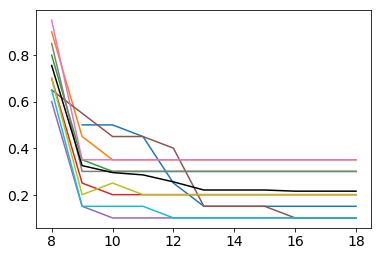

In [5]:
plt.figure()
plt.plot(vdp_data[0], vdp_data[1])
plt.plot(vdp_data[0], np.nanmean(vdp_data[1], axis=1), 'k')

### Show the average baseline duration on the attractor

(-2.2236618198767921,
 2.2236556197844868,
 -8.4009198354296508,
 8.400831907459299)

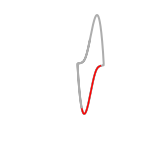

In [6]:
start_idx = int(5.3*sampling_rate_simulate)
end_idx = int(7*sampling_rate_simulate)
end_idx_highlight = int(5.5*sampling_rate_simulate)
spacing = 2**4

plt.figure(figsize=(2,2))
plt.plot(vdp_simulation[0,start_idx:end_idx:spacing], vdp_simulation[1,start_idx:end_idx:spacing],
         alpha=0.8, color='#999999', linewidth=2)
plt.plot(vdp_simulation[0,start_idx:end_idx_highlight:spacing],
         vdp_simulation[1,start_idx:end_idx_highlight:spacing], color='#ff0000')
plt.axis('equal')
plt.axis('off')
# plt.savefig('figures/02_vdp.pdf', format='pdf', dpi=300)

## Lorenz

### Simulate the system

In [7]:
sigma=10.
rho=28.
beta=8/3
tau = 1
period_length = .759*tau

x0 = [-8.0, 7.0, 27.0]

Xi_true = np.zeros((20,3))
Xi_true[1,0] = -sigma
Xi_true[2,0] = sigma
Xi_true[1,1] = rho
Xi_true[2,1] = -1
Xi_true[6,1] = -1
Xi_true[3,2] = -beta
Xi_true[5,2] = 1
Xi_true /= tau

poly_order = 3
coefficient_threshold = .1
tol = 1e-10

num_periods_simulate = 10
sampling_rate_simulate_exponent = 18
sampling_rate_simulate = 2**sampling_rate_simulate_exponent
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

lorenz_simulation = utils.simulate_lorenz(dt_simulate, t_simulate_full.size, x0=x0, sigma=sigma, rho=rho, beta=beta,
                                    tau=tau)[0]

### Subsample data and apply SINDy

In [8]:
test_durations = np.arange(.1,2.5,.05)
test_sampling_rates = np.arange(5,19)
test_starts = np.arange(0,1,.1)

extra_coefficients = np.zeros((test_durations.size, test_sampling_rates.size, test_starts.size))

for i,duration in enumerate(test_durations):
    for j,sampling_rate_exponent in enumerate(test_sampling_rates):
        for k,start_time in enumerate(test_starts):
            initial_samples = int((5+start_time)*sampling_rate_simulate)
            t_simulate = t_simulate_full[initial_samples:]
            lorenz_solution = lorenz_simulation[:,initial_samples:]
            
            # get subsamples
            sampling_rate = 2**sampling_rate_exponent
            t_max_idx = int(duration*sampling_rate_simulate)+1
            spacing = sampling_rate_simulate//sampling_rate

            t_sample = t_simulate[:t_max_idx:spacing]
            dt_sample = t_sample[1] - t_sample[0]

            sampled_data = lorenz_solution[:,:t_max_idx:spacing]

            sindy = utils.SINDy()
            sindy.fit(sampled_data, poly_order, t=dt_sample, coefficient_threshold=coefficient_threshold)
            extra_coefficients[i,j,k] = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                                                  | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size

boundaries = np.zeros((test_sampling_rates.size, test_starts.size))
for k,start_time in enumerate(test_starts):
    boundaries[:,k] = find_boundary(extra_coefficients[:,:,k].T, test_durations)
lorenz_data = [test_sampling_rates, boundaries]
lorenz_data2 = [test_durations, extra_coefficients]

### Plot the range of data requirements for all portions of the attractor

/home/kpchamp/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


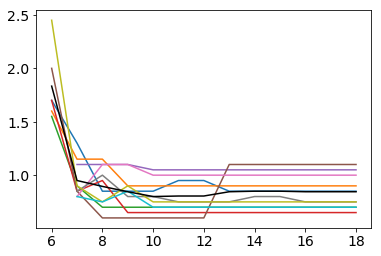

In [9]:
plt.figure()
plt.plot(lorenz_data[0], lorenz_data[1])
plt.plot(lorenz_data[0], np.nanmean(lorenz_data[1], axis=1), 'k')

### Show at what sampling rates/durations the system is and is not correctly identified

/home/kpchamp/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


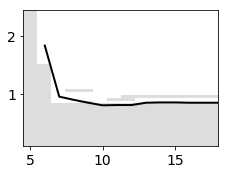

In [10]:
cmap_shading = colors.ListedColormap(['white', '#dddddd'])
norm_shading = colors.BoundaryNorm([0,1,10], cmap_shading.N)

plt.figure(figsize=(3.5,2.5))
plt.plot(lorenz_data[0], np.nanmean(lorenz_data[1],axis=1), '-k', linewidth=2)
plt.imshow(np.mean(lorenz_data2[1][::-1,:,:],axis=2), cmap=cmap_shading, norm=norm_shading, interpolation='nearest',
          aspect='auto', extent=[lorenz_data[0][0]-.5, lorenz_data[0][-1],lorenz_data2[0][0],lorenz_data2[0][-1]])
# plt.savefig('figures/02_sampling_lorenz.pdf', format='pdf', dpi=300)

### Show the average baseline duration on the attractor

(-18.711907266995201,
 19.491577301761811,
 -24.585989380467449,
 26.012622436875088)

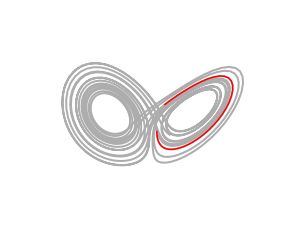

In [11]:
num_periods_simulate = 30
sampling_rate_simulate_exponent = 12
sampling_rate_simulate = 2**sampling_rate_simulate_exponent
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

lorenz_simulation = utils.simulate_lorenz(dt_simulate, t_simulate_full.size, sigma=sigma, rho=rho, beta=beta,
                                    tau=tau)[0]

start_idx = int(5*sampling_rate_simulate)
end_idx = -1
end_idx_highlight = int(5.85*sampling_rate_simulate)
spacing = 2**6

# find the max index at which to plot the solution
sample_max_idx = int(0.85*period_length/dt_simulate)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(lorenz_simulation[0,start_idx:end_idx:spacing], lorenz_simulation[1,start_idx:end_idx:spacing],
        lorenz_simulation[2,start_idx:end_idx:spacing], alpha=0.8, color='#999999', linewidth=2)
plt.plot(lorenz_simulation[0,start_idx:end_idx_highlight:spacing],
         lorenz_simulation[1,start_idx:end_idx_highlight:spacing],
         lorenz_simulation[2,start_idx:end_idx_highlight:spacing],
         color='#ff0000')
ax.axis('off')
# plt.savefig('figures/02_lorenz.pdf', format='pdf', dpi=300)

## Duffing

### Simulate the system

In [12]:
alpha = 1
beta = 4
tau = 1
period_length = 3.179*tau

x0 = [1.0,0.0,0.0]

Xi_true = np.zeros((10,2))
Xi_true[1,1] = -alpha
Xi_true[2,0] = 1.
Xi_true[6,1] = -beta
Xi_true /= tau

poly_order = 3
coefficient_threshold = .1
tol = 1e-10

num_periods_simulate = 10
sampling_rate_simulate_exponent = 18
sampling_rate_simulate = 2**sampling_rate_simulate_exponent
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

duffing_simulation = utils.simulate_duffing_oscillator(dt_simulate, t_simulate_full.size, x0=x0, alpha=alpha, beta=beta,
                                                 tau=tau)[0][0:2]

### Subsample data and apply SINDy

In [13]:
test_durations = np.arange(.1,1,.05)
test_sampling_rates = np.arange(5,19)
test_starts = np.arange(0,1,.1)

extra_coefficients = np.zeros((test_durations.size, test_sampling_rates.size, test_starts.size))

for i,duration in enumerate(test_durations):
    for j,sampling_rate_exponent in enumerate(test_sampling_rates):
        for k,start_time in enumerate(test_starts):
            initial_samples = int((5+start_time)*sampling_rate_simulate)
            t_simulate = t_simulate_full[initial_samples:]
            duffing_solution = duffing_simulation[:,initial_samples:]
            
            # get subsamples
            sampling_rate = 2**sampling_rate_exponent
            t_max_idx = int(duration*sampling_rate_simulate)+1
            spacing = sampling_rate_simulate//sampling_rate

            t_sample = t_simulate[:t_max_idx:spacing]
            dt_sample = t_sample[1] - t_sample[0]

            sampled_data = duffing_solution[:,:t_max_idx:spacing]

            sindy = utils.SINDy()
            sindy.fit(sampled_data, poly_order, t=dt_sample, coefficient_threshold=coefficient_threshold)
            extra_coefficients[i,j,k] = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                                                  | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size

boundaries = np.zeros((test_sampling_rates.size, test_starts.size))
for k,start_time in enumerate(test_starts):
    boundaries[:,k] = find_boundary(extra_coefficients[:,:,k].T, test_durations)
duffing_data = [test_sampling_rates, boundaries]

### Plot the range of data requirements for all portions of the attractor

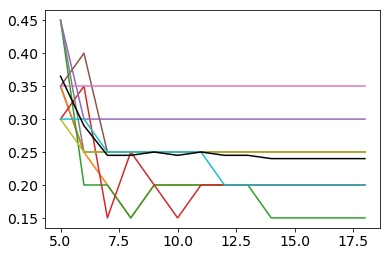

In [14]:
plt.figure()
plt.plot(duffing_data[0], duffing_data[1])
plt.plot(duffing_data[0], np.nanmean(duffing_data[1], axis=1), 'k')

### Show the average baseline duration on the attractor

(-1.1000798934242517,
 1.1000758892108191,
 -1.9054745551801413,
 1.9054841127883311)

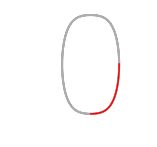

In [15]:
start_idx = int(5*sampling_rate_simulate)
end_idx = int(7*sampling_rate_simulate)
end_idx_highlight = int(5.25*sampling_rate_simulate)
spacing = 2**4

plt.figure(figsize=(2,2))
plt.plot(duffing_simulation[0,start_idx:end_idx:spacing], duffing_simulation[1,start_idx:end_idx:spacing],
         alpha=0.8, color='#999999', linewidth=2)
plt.plot(duffing_simulation[0,start_idx:end_idx_highlight:spacing],
         duffing_simulation[1,start_idx:end_idx_highlight:spacing], color='#ff0000')
plt.axis('equal')
plt.axis('off')
# plt.savefig('figures/02_duffing.pdf', format='pdf', dpi=300)

## Rossler

In [16]:
a = 0.1
b = 0.1
c = 14
tau=.1

x0 = [0.0, 10.0, 0.0]

period_length = 6.14*tau

Xi_true = np.zeros((20,3))
Xi_true[0,2] = b
Xi_true[1,1] = 1
Xi_true[2,0] = -1
Xi_true[2,1] = a
Xi_true[3,0] = -1
Xi_true[3,2] = -c
Xi_true[6,2] = 1
Xi_true /= tau

poly_order = 3
coefficient_threshold = .1
tol = 1e-10

num_periods_simulate = 10
sampling_rate_simulate_exponent = 18
sampling_rate_simulate = 2**sampling_rate_simulate_exponent
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

rossler_simulation = utils.simulate_rossler(dt_simulate, t_simulate_full.size, x0=x0, a=a, b=b, c=c, tau=tau)[0]

### Subsample data and apply SINDy

In [17]:
test_durations = np.arange(.1,2,.05)
test_sampling_rates = np.arange(5,19)
test_starts = np.arange(0,1,.1)

extra_coefficients = np.zeros((test_durations.size, test_sampling_rates.size, test_starts.size))

for i,duration in enumerate(test_durations):
    for j,sampling_rate_exponent in enumerate(test_sampling_rates):
        for k,start_time in enumerate(test_starts):
            initial_samples = int((5+start_time)*sampling_rate_simulate)
            t_simulate = t_simulate_full[initial_samples:]
            rossler_solution = rossler_simulation[:,initial_samples:]
            
            # get subsamples
            sampling_rate = 2**sampling_rate_exponent
            t_max_idx = int(duration*sampling_rate_simulate)+1
            spacing = sampling_rate_simulate//sampling_rate

            t_sample = t_simulate[:t_max_idx:spacing]
            dt_sample = t_sample[1] - t_sample[0]

            sampled_data = rossler_solution[:,:t_max_idx:spacing]

            sindy = utils.SINDy()
            sindy.fit(sampled_data, poly_order, t=dt_sample, coefficient_threshold=coefficient_threshold)
            extra_coefficients[i,j,k] = np.where(((np.abs(Xi_true) < tol) & (np.abs(sindy.Xi) > tol))\
                                                  | ((np.abs(Xi_true) > tol) & (np.abs(sindy.Xi) < tol)))[0].size

boundaries = np.zeros((test_sampling_rates.size, test_starts.size))
for k,start_time in enumerate(test_starts):
    boundaries[:,k] = find_boundary(extra_coefficients[:,:,k].T, test_durations)
rossler_data = [test_sampling_rates, boundaries]

### Plot the range of data requirements for all portions of the attractor

/home/kpchamp/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


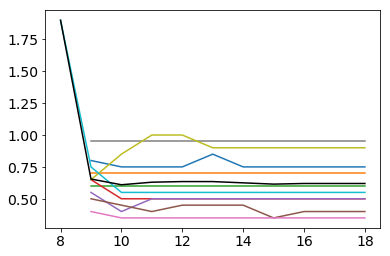

In [18]:
plt.figure()
plt.plot(rossler_data[0], rossler_data[1])
plt.plot(rossler_data[0], np.nanmean(rossler_data[1], axis=1), 'k')

### Show the average baseline duration on the attractor

(-21.57888607236643,
 24.240539051986286,
 -23.104101652193023,
 20.02789328035928)

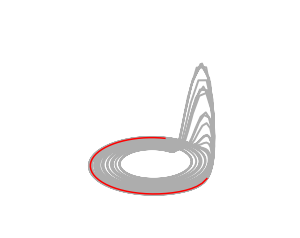

In [19]:
num_periods_simulate = 30
sampling_rate_simulate_exponent = 12
sampling_rate_simulate = 2**sampling_rate_simulate_exponent
t_simulate_full = np.linspace(0, num_periods_simulate*period_length,
                int(num_periods_simulate*sampling_rate_simulate))
dt_simulate = t_simulate_full[1]-t_simulate_full[0]

rossler_simulation = utils.simulate_rossler(dt_simulate, t_simulate_full.size, x0=x0, a=a, b=b, c=c, tau=tau)[0]

start_idx = int(5.1*sampling_rate_simulate)
end_idx = -1
end_idx_highlight = int(5.8*sampling_rate_simulate)
spacing = 2**6

# find the max index at which to plot the solution
sample_max_idx = int(0.85*period_length/dt_simulate)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(rossler_simulation[0,start_idx:end_idx:spacing], rossler_simulation[1,start_idx:end_idx:spacing],
        rossler_simulation[2,start_idx:end_idx:spacing], alpha=0.8, color='#999999', linewidth=2)
plt.plot(rossler_simulation[0,start_idx:end_idx_highlight:spacing],
         rossler_simulation[1,start_idx:end_idx_highlight:spacing],
         rossler_simulation[2,start_idx:end_idx_highlight:spacing],
         color='#ff0000')
ax.axis('off')
# plt.savefig('figures/02_rossler.pdf', format='pdf', dpi=300)

# Plot results for all systems

/home/kpchamp/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Mean of empty slice
  
/home/kpchamp/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
/home/kpchamp/anaconda/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


(0.15, 1.5)

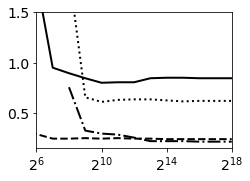

In [20]:
plt.figure(figsize=(3.5,2.5))
plt.semilogx(2**lorenz_data[0], np.nanmean(lorenz_data[1], axis=1), 'k', linewidth=2, label='Lorenz', basex=2)

plt.semilogx(2**duffing_data[0], np.nanmean(duffing_data[1], axis=1), 'k--', linewidth=2, label='Duffing', basex=2)

plt.semilogx(2**vdp_data[0], np.nanmean(vdp_data[1], axis=1), 'k-.', linewidth=2, label='Van der Pol', basex=2)

plt.semilogx(2**rossler_data[0], np.nanmean(rossler_data[1], axis=1), 'k:', linewidth=2, label='Rossler', basex=2)
plt.xlim([2**6,2**18])
plt.ylim([0.15,1.5])

# plt.legend()
# plt.savefig('figures/02_sampling_all.pdf', format='pdf', dpi=300)